In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.ticker as ticker
sns.set()

In [2]:
#Build NA covid data for all airport comparisons
# Build total + new NA cases
NaData = pd.read_csv("Archieved-Data/casesNA.csv", compression = 'gzip')
NaData["Date"] = pd.to_datetime(NaData["Date"])
NaSums = NaData.groupby(NaData['Date']).sum().reset_index()
naCases = NaSums[['Date','Confirmed']]
temp = naCases.shift(1)
naCases['New'] = naCases['Confirmed'] - temp['Confirmed']
naCases.loc[0,"New"] = 0
new_cases_smooth = lowess(naCases['New'], naCases["Date"], frac =0.05)
confirm_smooth = lowess(naCases['Confirmed'], naCases["Date"], frac =0.05)
naCases['New_smooth'] = new_cases_smooth[:,1]
naCases['Confirm_smooth'] = confirm_smooth[:,1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [3]:
yyz = pd.read_csv('yyz4analyze_both.csv',index_col =0, parse_dates = [1])
yyzCases = pd.read_csv('Covid-Data/yyz-modified.csv', index_col =0, parse_dates = [5])

yyz["Date"] = pd.to_datetime(yyz["Date"])
yyzCases["Date"] = pd.to_datetime(yyzCases["Date"])

yyzCases.loc[0, "Difference"] = 0

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


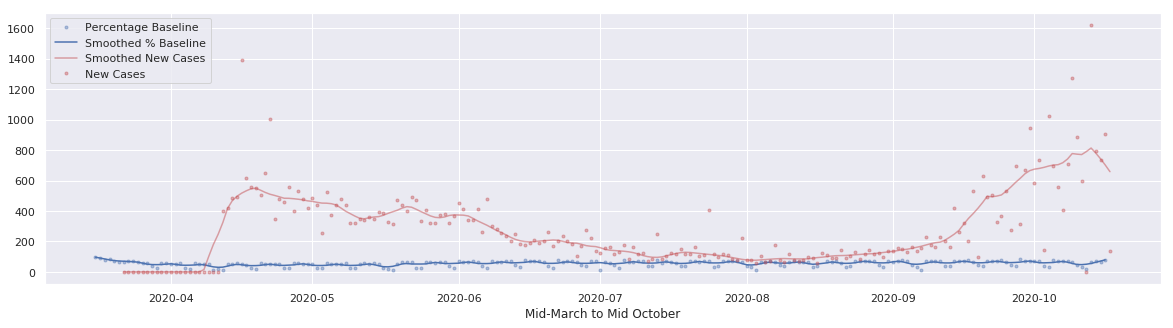

In [4]:
# baseline seems constant; except for the small dip in March
# Find factors to attribute to the two curves - small bump in the summer?
# The second one might be an instance to not increase flights to YYZ
# lots of 0s in the beginning.... averaging or imputing the missing values might have been a good idea

new_cases_smooth = lowess(yyzCases['Difference'], yyzCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yyz['PercentOfBaseline'], yyz["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yyzCases['Diff_smooth'] = new_cases_smooth[:,1]
yyz['Baseline_smooth'] = baseline_smooth[:,1]
# Ensure both yul and yulCases start and end on the same dates
if (yyz.count().loc['Date'] != yyzCases.count().loc['Date']):
    joined = yyzCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yyz[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yyzCases["Diff_smooth"]
    y = yyz["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yyz["Date"], yyz['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yyz["Date"], yyz['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yyzCases["Date"], yyzCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yyzCases["Date"], yyzCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

-0.08368474709035637


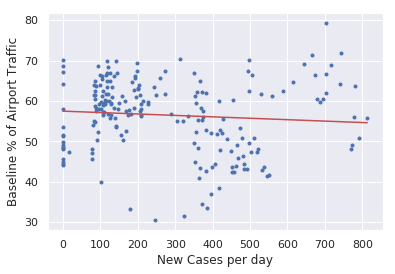

In [5]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

# 311 = max(X)
linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')

# r-value: Slight but negligible correlation 
# imbalanced data??

0.6083082642199132


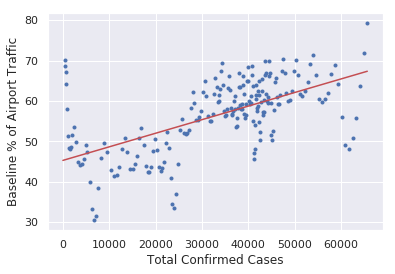

In [7]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')

# this is pretty interesting - strong indication of positive correlation

0.457510429441416
-0.8656262976469603


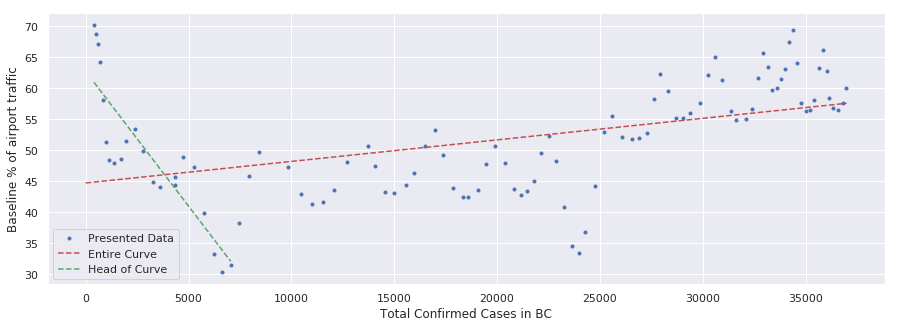

In [41]:
# Analyzing statistical correlation in --> full first wave
first_wave = joined[joined['Date']<'2020-07-01']
plt.figure(figsize = (15,5))

plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.', label = 'Presented Data')
plt.xlabel("Total Confirmed Cases in BC")
plt.ylabel("Baseline % of airport traffic")

regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)

linearX = np.linspace(0,37000)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--', label = 'Entire Curve')

# We can clearly see that while there was a huge decrease in airport traffic in the 
# beginning, but it recovered over time back to the new normal
# how about when we try to only look at the first 22 days? 
reg2 = stats.linregress(first_wave["Confirmed"].head(22), first_wave["Baseline_smooth"].head(22))
print(reg2.rvalue)
lin2 = np.linspace(400,max(first_wave["Confirmed"].head(22)))
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--', label = 'Head of Curve')
# get rvalue showing there is indeed a close linear correlation in the first 'shock'
# but later on, no longer the same correlation"""
plt.legend()

-0.20441697447271215
0.32749092870942875
-0.5898925834748836


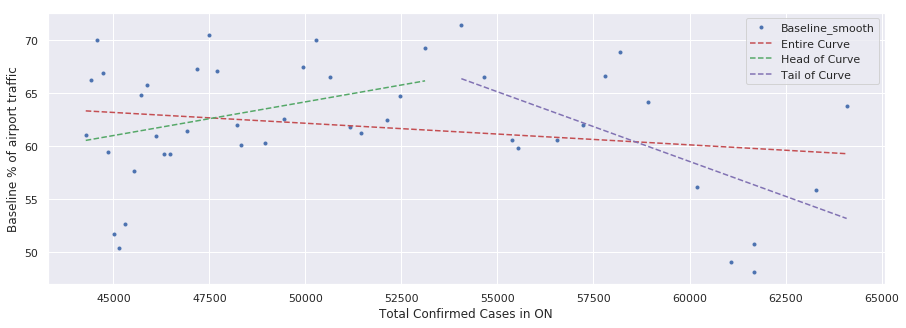

In [54]:
# Analyzing statistical correlation in --> Second Wave
sec_wave = joined[joined['Date']<'2020-10-15']
sec_wave = sec_wave[sec_wave['Date'] > '2020-08-30']
plt.figure(figsize = (15,5))

plt.plot(sec_wave["Confirmed"],sec_wave["Baseline_smooth"], 'b.')
plt.xlabel("Total Confirmed Cases in ON")
plt.ylabel("Baseline % of airport traffic")

regression = stats.linregress(sec_wave["Confirmed"], sec_wave["Baseline_smooth"])
print(regression.rvalue)
# No correlation - are people used to the pandemic by now?
linearX = np.linspace(min(sec_wave['Confirmed']),max(sec_wave['Confirmed']))
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--', label = 'Entire Curve')

# Sept - start of the second wave
reg2 = stats.linregress(sec_wave["Confirmed"].head(30), sec_wave["Baseline_smooth"].head(30))
print(reg2.rvalue)
# weak correlation
lin2 = np.linspace(min(sec_wave['Confirmed'].head(30)),max(sec_wave["Confirmed"].head(30)))
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--', label = 'Head of Curve')

# Oct - decline of second curve 
reg3 = stats.linregress(sec_wave["Confirmed"].tail(15), sec_wave["Baseline_smooth"].tail(15))
print(reg3.rvalue)
# Moderate correlation
lin3 = np.linspace(min(sec_wave['Confirmed'].tail(15)),max(sec_wave["Confirmed"].tail(15)))
plt.plot(lin3, reg3.slope*lin3+ reg3.intercept,'m--', label = 'Tail of Curve')
plt.legend()

# seems like people are opting to travel less - why?

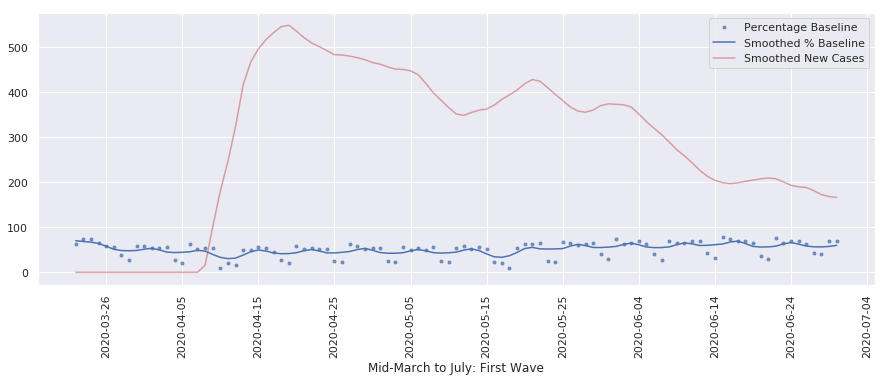

In [31]:
plt.figure(figsize = (15,5))
plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
#plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to July: First Wave")
plt.legend()
plt.xticks(rotation=90)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
#first_wave

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


0.6820162012229175
0.6779335884462216


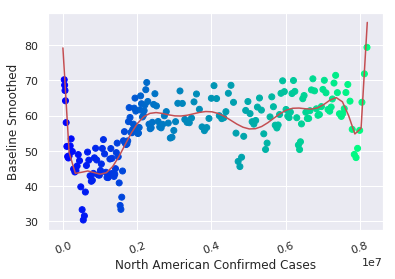

In [34]:
 # This is to make sure both yvr and naCases start and end on the same dates
if (yyz.count().loc['Date'] != naCases.count().loc['Date']):
    na = naCases[["Date","Confirmed","New"]].join(yyz[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    na = na.dropna()

plt.scatter(na['Confirmed'],na['Baseline_smooth'],c=na['Date'],cmap='winter' )
plt.xlabel("North American Confirmed Cases")
plt.xticks(rotation=20)
plt.ylabel("Baseline Smoothed")

X = np.stack([na['Confirmed']], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,np.stack([na['Baseline_smooth']], axis =1))

poly_regress = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=12, include_bias = True),
    LinearRegression(fit_intercept = False))
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,8200000)],axis=1)

plt.plot(linearX, poly_regress.predict(linearX), 'r-')
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))

In [35]:
# ML with new cases, total cases, na cases: total + new, vs y= Baseline
#naCases --> Confirmed, New, New_smooth, Confirm_smooth
#joined --> Confirmed, Confirmed_smooth, Difference, Diff_smooth, Baseline_smooth, PercentOfBaseline

joined["Confirmed_smooth"] = confirmX
joined
# X --> na_confirm, na_new, bc_confirm, bc_new
X = naCases[["Confirm_smooth", "New_smooth", "Date"]].join(joined[["Confirmed_smooth","Diff_smooth","Date"]].set_index('Date'), on ='Date')
X = X.rename(columns={"Confirm_smooth": "na_confirm", "New_smooth":"na_new", "Confirmed_smooth":"on_confirm", "Diff_smooth":"on_new"})
X = X[["na_confirm","na_new","on_confirm","on_new"]].dropna()

# y --> joined['Baseline_smooth']
y = joined['Baseline_smooth'].rename(columns={"Baseline_smooth":"yyzBaseline"})

In [13]:
 # GB regressor does the best out of all of them bc diff factors are weighed differently
# Also not that much data, so neural network doesn't really work
gbmodel = make_pipeline(
    MinMaxScaler(),
    GradientBoostingRegressor(n_estimators=50, max_depth=5)
    )
gbmodel.fit(X_train, y_train)

print(gbmodel.score(X_train,y_train), gbmodel.score(X_valid,y_valid))

0.9521774719615359 0.8898784277177603


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
